# Исследование надежности заемщиков

## Описание проекта

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


## Откроем таблицу и изучим общую информацию о данных

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('/data.csv')
data.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Удаление пропусков

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Один из них — `days_employed`.  Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполним пропуски в этом столбце медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В данных есть артефакты (аномалии) — отрицательное количество дней трудового стажа в столбце `days_employed`. Обработаем значения в этом столбце: заменим все отрицательные значения положительными с помощью метода `abs()`.

In [7]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.**

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть.

перечень уникальных значений столбца `children`.

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [11]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполним пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.**

In [12]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Убедимся, что все пропуски заполнены.

In [13]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [14]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`.

In [15]:
data['education'] = data['education'].str.lower()

In [16]:
data.duplicated().sum()

71

In [17]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [18]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E (0–30000)'
        elif 30001 <= income <= 50000:
            return 'D (30001–50000)'
        elif 50001 <= income <= 200000:
            return 'C (50001–200000)'
        elif 200001 <= income <= 1000000:
            return 'B (200001–1000000)'
        elif income >= 1000001:
            return 'A (1000001 и выше)'
    except:
        pass

In [19]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведим на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [20]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [21]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [22]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Шаг 3. Исследуйте данные и ответьте на вопросы

#### 3.1 Есть ли зависимость между количеством детей и возвратом кредита в срок?

Добавим столбец `child_free` для деления на категорию по наличию / отсутствию детей

In [23]:
data['having_children'] = 'yes'
data.loc[data['children'] == 0,'having_children'] = 'no'

Сделаем группировку по столбцу `children`

In [24]:
children_debt = data.groupby('children', as_index=False)['debt'].agg( ['count', 'mean'])
children_debt.reset_index(inplace=True)
children_debt

,index,children,count,mean
0,0,0,14091,0.075438
1,1,1,4808,0.092346
2,2,2,2052,0.094542
3,3,3,330,0.081818
4,4,4,41,0.097561
5,5,5,9,0.000000


Выведем диаграмму:

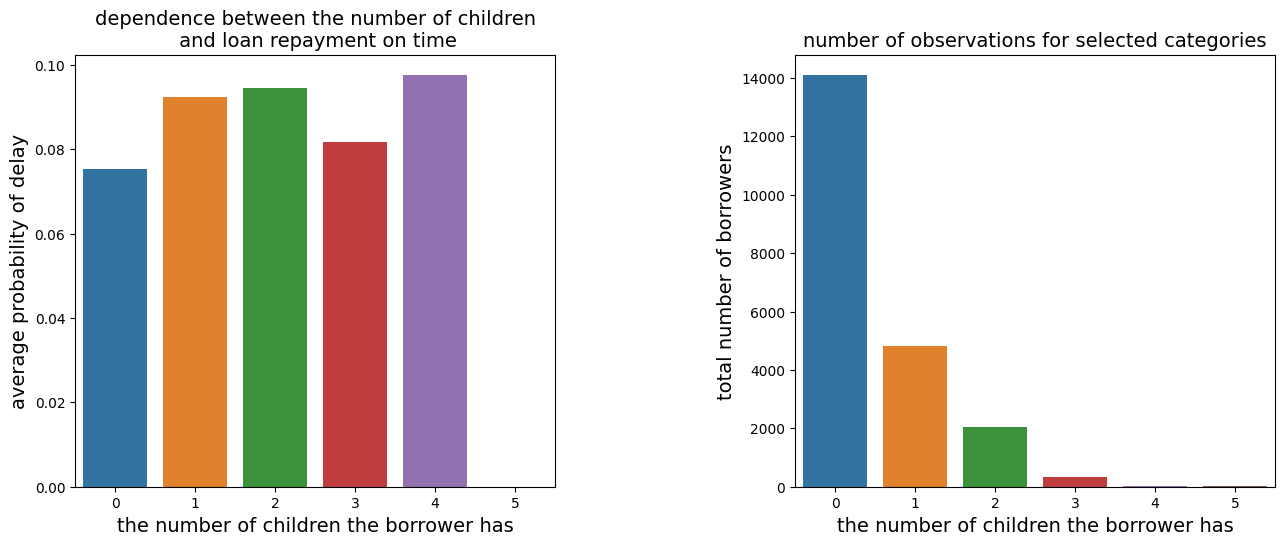

In [25]:
plt.subplot(1, 2, 1)
bx = sns.barplot(x='children', y='mean', data=children_debt)
bx.set_title('dependence between the number of children\n and loan repayment on time', fontsize=14)
bx.set_xlabel('the number of children the borrower has', fontsize=14)
bx.set_ylabel('average probability of delay', fontsize=14)

plt.subplot(1, 2, 2)
ax = sns.barplot(x='children', y='count', data=children_debt)
ax.set_xlabel('the number of children the borrower has', fontsize=14)
ax.set_ylabel("total number of borrowers", fontsize=14)
ax.set_title('number of observations for selected categories', fontsize=14)

plt.subplots_adjust(hspace = 0.5, wspace=0.5, top=1, bottom=0.1, right=2)

Столбцы 1 и 2 близки по значению. Столбцы 3,4,5 имеют незначительное количество наблюдений, сделать достоверные выводы по ним не получится. Объединим столбцы 1-5.
Сделаем группировку по столбцу `child_free`

In [26]:
having_children_debt = data.groupby('having_children')['debt'].agg( ['count', 'mean'])
having_children_debt.reset_index(inplace=True)
having_children_debt

,having_children,count,mean
0,no,14091,0.075438
1,yes,7240,0.092403


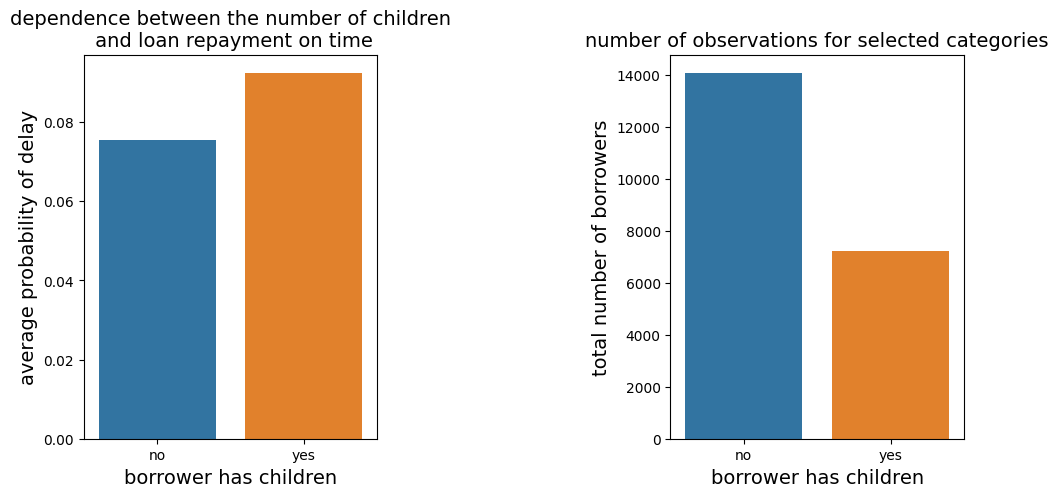

In [27]:
plt.subplot(1, 2, 1)
ax = sns.barplot(x='having_children', y='mean', data=having_children_debt)
ax.set_title('dependence between the number of children\n and loan repayment on time', fontsize=14)
ax.set_xlabel('borrower has children', fontsize=14)
ax.set_ylabel('average probability of delay', fontsize=14)

plt.subplot(1, 2, 2)
bx = sns.barplot(x='having_children', y='count', data=having_children_debt)
bx.set_xlabel('borrower has children', fontsize=14)
bx.set_ylabel("total number of borrowers", fontsize=14)
bx.set_title('number of observations for selected categories', fontsize=14)

plt.subplots_adjust(hspace = 1, wspace=1, top=1, bottom=0.2, right=1.5)

Посчитаем соотношение просрочки кредита заемщиков с детьми к бездетным:

In [28]:
round(having_children_debt.loc[0, 'mean'] / having_children_debt.loc[1, 'mean'], 2)

0.82

**Вывод:** Заемщики с детьми в 1,22 раза чаще выходят на просрочку кредита

#### 3.2 Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [29]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category,having_children
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B (200001–1000000),операции с недвижимостью,yes
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C (50001–200000),операции с автомобилем,yes
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C (50001–200000),операции с недвижимостью,no
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B (200001–1000000),получение образования,yes
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C (50001–200000),проведение свадьбы,no


Сделаем группировку по столбцу `family_status`

In [30]:
family_status_debt = data.groupby('family_status')['debt'].agg( ['count', 'mean'])
family_status_debt.reset_index(inplace=True)
family_status_debt.sort_values('mean', inplace=True)
family_status_debt['div_mean']  = family_status_debt['mean'] / family_status_debt['mean'].min()
family_status_debt

,family_status,count,mean,div_mean
2,вдовец / вдова,951,0.066246,1.000000
1,в разводе,1189,0.070648,1.066442
4,женат / замужем,12261,0.075606,1.141284
3,гражданский брак,4134,0.093130,1.405822
0,Не женат / не замужем,2796,0.097639,1.473891


Построим диаграмму:

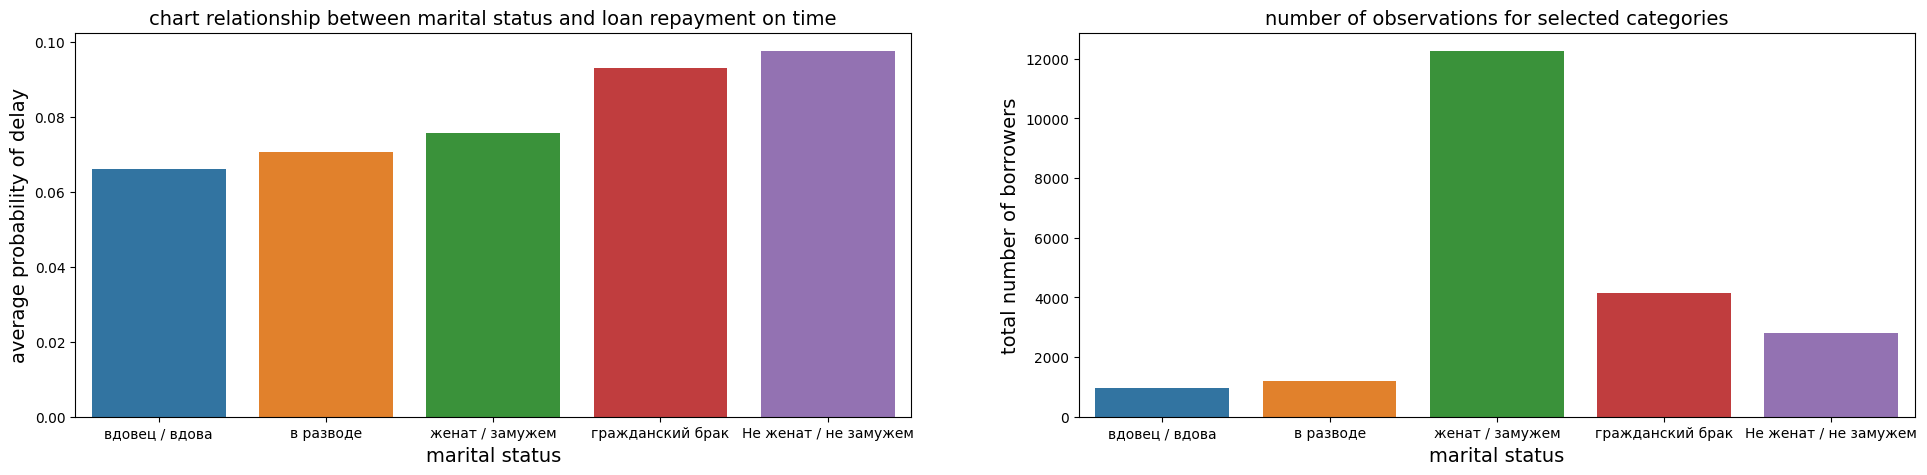

In [31]:
plt.subplot(1, 2, 1)
ax = sns.barplot(x='family_status', y='mean', data=family_status_debt)
ax.set_title('chart relationship between marital status and loan repayment on time', fontsize=14)
ax.set_xlabel('marital status', fontsize=14)
ax.set_ylabel('average probability of delay', fontsize=14)

plt.subplot(1, 2, 2)
bx = sns.barplot(x='family_status', y='count', data=family_status_debt)
bx.set_ylabel("total number of borrowers", fontsize=14)
bx.set_xlabel('marital status', fontsize=14)
bx.set_title('number of observations for selected categories', fontsize=14)

plt.subplots_adjust(hspace = 1, wspace=0.2, top=1, bottom=0.2, right=3)

посчитаем отношение к минимальному среднему значению вероятности просрочки:

In [32]:
family_status_debt['mean'] / family_status_debt['mean'].min()

2    1.000000
1    1.066442
4    1.141284
3    1.405822
0    1.473891
Name: mean, dtype: float64

**Вывод:** Вероятность просрочки возрастает от `вдовец / вдова`	к `Не женат / не замужем` в 1,47 раза. Здесь вероятно имеется сильное смещение по возрасту, что могло повлиять результат.

#### 3.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Категории дохода:
- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

Сделаем группировку по столбцу `total_income_category`

In [33]:
income_debt = data.groupby('total_income_category')['debt'].agg( ['count', 'mean'])
income_debt.reset_index(inplace=True)
income_debt.sort_values('mean', inplace=True)
income_debt['div_mean']  = income_debt['mean'] / income_debt['mean'].min()
income_debt

,total_income_category,count,mean,div_mean
3,D (30001–50000),349,0.060172,1.000000
1,B (200001–1000000),5014,0.070602,1.173343
0,A (1000001 и выше),25,0.080000,1.329524
2,C (50001–200000),15921,0.084982,1.412322
4,E (0–30000),22,0.090909,1.510823


Построим диаграмму:

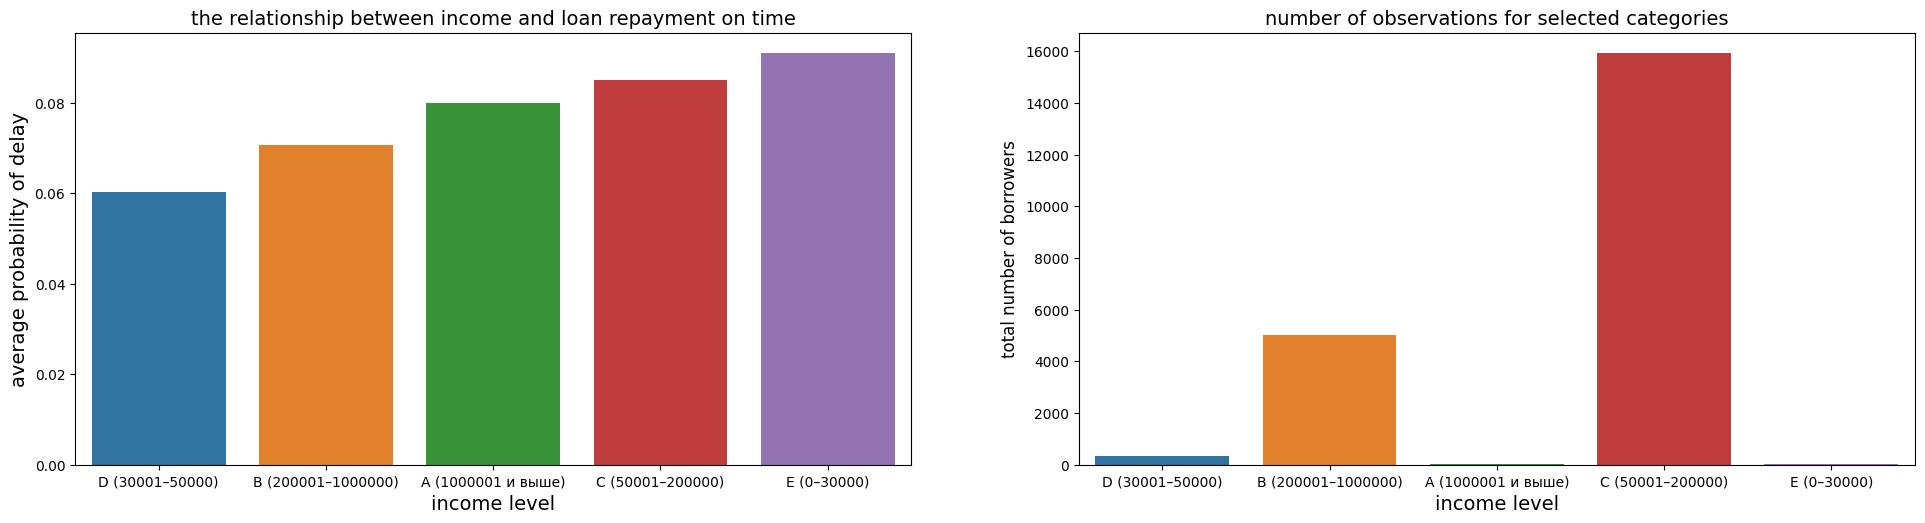

In [34]:
plt.subplot(1, 2, 1)
ax = sns.barplot(x='total_income_category', y='mean', data=income_debt)
ax.set_title('the relationship between income and loan repayment on time', fontsize=14)
ax.set_xlabel('income level', fontsize=14)
ax.set_ylabel('average probability of delay', fontsize=14)

plt.subplot(1, 2, 2)
bx = sns.barplot(x='total_income_category', y='count', data=income_debt)
bx.set_ylabel("total number of borrowers", fontsize=12)
bx.set_xlabel('income level', fontsize=14)
bx.set_title('number of observations for selected categories', fontsize=14)

plt.subplots_adjust(hspace = 1, wspace=0.2, top=1, bottom=0.1, right=3)

По категориям А, D и Е недостаточно данных для достоверного анализа. Оставим только выборки с количеством наблюдений больше 500

In [41]:
income_debt_reliably = income_debt.loc[income_debt['count'] > 500].copy()

In [42]:
income_debt_reliably['div_mean']  = income_debt_reliably['mean'] / (income_debt_reliably['mean'].min()) - 1
income_debt_reliably

,total_income_category,count,mean,div_mean
1,B (200001–1000000),5014,0.070602,0.000000
2,C (50001–200000),15921,0.084982,0.203673


Построим диаграмму:

Text(0, 0.5, 'average probability of delay')

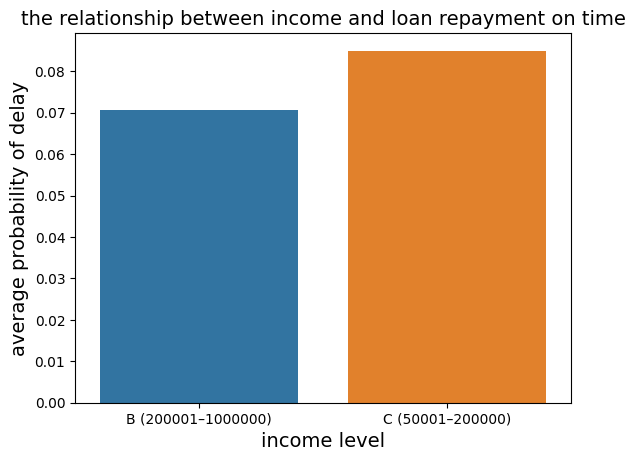

In [43]:
ax = sns.barplot(x='total_income_category', y='mean', data=income_debt_reliably)
ax.set_title('the relationship between income and loan repayment on time', fontsize=14)
ax.set_xlabel('income level', fontsize=14)
ax.set_ylabel('average probability of delay', fontsize=14)

**Вывод:** По категориям В и С можно сделать вывод о увеличении вероятности просрочки в 1,2 раза с  уменьшением дохода с `200001–1000000 — 'B'`  до  `50001–200000 — 'C'`

#### 3.4 Как разные цели кредита влияют на его возврат в срок?

Сделаем группировку по столбцу `purpose_category`

In [44]:
purpose_debt = data.groupby('purpose_category')['debt'].agg( ['count', 'mean'])
purpose_debt.reset_index(inplace=True)
purpose_debt.sort_values('mean', inplace=True)
purpose_debt['div_mean'] = purpose_debt['mean'] / purpose_debt['mean'].min()
purpose_debt

,purpose_category,count,mean,div_mean
1,операции с недвижимостью,10751,0.072551,1.000000
3,проведение свадьбы,2313,0.079118,1.090510
2,получение образования,3988,0.092528,1.275339
0,операции с автомобилем,4279,0.093480,1.288463


Построим диаграмму:

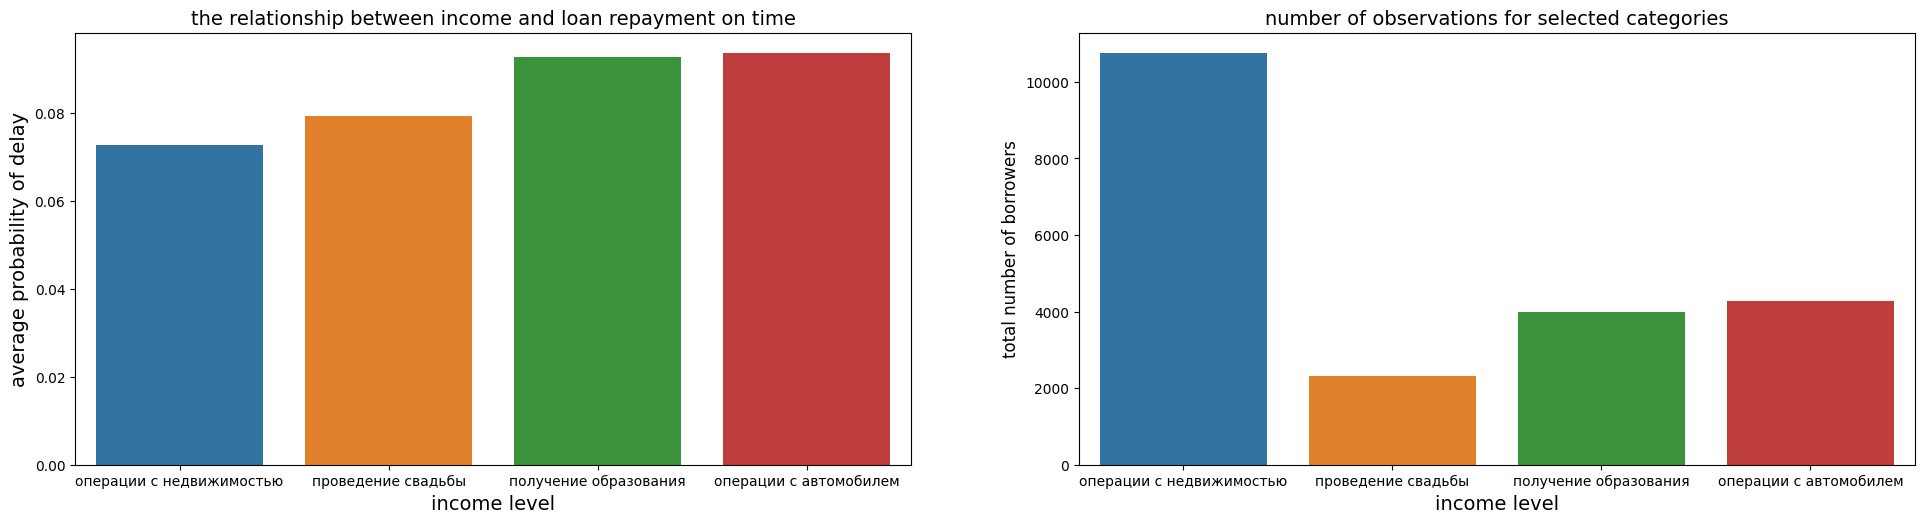

In [45]:
plt.subplot(1, 2, 1)
ax = sns.barplot(x='purpose_category', y='mean', data=purpose_debt)
ax.set_title('the relationship between income and loan repayment on time', fontsize=14)
ax.set_xlabel('income level', fontsize=14)
ax.set_ylabel('average probability of delay', fontsize=14)

plt.subplot(1, 2, 2)
bx = sns.barplot(x='purpose_category', y='count', data=purpose_debt)
bx.set_ylabel("total number of borrowers", fontsize=12)
bx.set_xlabel('income level', fontsize=14)
bx.set_title('number of observations for selected categories', fontsize=14)

plt.subplots_adjust(hspace = 1, wspace=0.2, top=1, bottom=0.1, right=3)

**Вывод:** У нас есть достаточное количество наблюдений по всем категориям для анализа. Наименее рисковые кредиты выдают на `операции с недвижимостью`, риск повышается на 28% на `получение образования` и `операции с автомобилем`

#### 3.5 возможные причины появления пропусков в исходных данных.

Вероятно данные не предоставлены клиентом или из-за технических ошибок (например, при выгрузке данных)

### Шаг 4: общий вывод.

Для выполнения поставленной задачи о влиянии семейного положения и количества детей клиента банка на факт погашения кредита в срок был проведен анализ статистики о платёжеспособности клиентов.  
Была проведена предобработка данных: удалили пропуски, дубликаты, добавили новые категории.

Для анализа количества детей клиента на факт погашения кредита в срок добавили категорию `наличия / отсутствия детей`, так как выборки на 3,4,5 детей были слишком малы для достоверного вывода, а выборки на 1 и 2 ребенка показали близкие результаты.   

Выявлены следующие тендеции: 
- заемщики с детьми в среднем в 1,22 раза чаще выходят на просрочку кредита
- анализ влияния семейного положения показал большой разброс вероятности нарушения срока оплаты по категориям
- увеличениe вероятности просрочки от `вдовец / вдова` к `Не женат / не замужем` в 1,47 раза.
- увеличениe вероятности просрочки в 1,2 раза с  уменьшением диапазона дохода с `200001–1000000  до  `50001–200000`
- наименее рисковые кредиты выдают на `операции с недвижимостью`, риск повышается на 28% на `получение образования` и `операции с автомобилем`

Мы наблюдаем сильно выраженные зависимости кредитного риска от принадлежности к определенной категории. Применение роботов для решения о выдаче кредита снизит риски неплатежей и даст высокий экономический эффект.